In [1]:
%load_ext autoreload
%autoreload 2

# Add other paths
import os, sys
sys.path.append(os.path.abspath(os.path.join("../")))
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import helper_libraries.results_tools as results_tools
import multiprocessing
import functools
import sklearn.linear_model
import warnings
from tqdm.auto import tqdm
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Import data

## News

In [2]:
# Params
news_counts_directory = '../../../../GitHub/SDF-HF/data/proc/news_counts'

In [53]:
news_counts_df = pd.read_parquet(f'{news_counts_directory}')
news_counts_df.columns = [x.replace('&', 'and') for x in news_counts_df.columns]

# # Remove certain topics
# news_counts_df = news_counts_df.drop(['nasd', 'pensions', 'earnings_losses'], axis=1)

# Fix missing
news_counts_df = news_counts_df.fillna(0)

# Get list of all topics
news_key_terms = list(news_counts_df.columns)[:-1]

## Returns and Spreads

In [54]:
# Load returns and spreads
fret_df, hrf_df = results_tools.load_mkt_rf_returns()
spread_df = results_tools.load_spreads()

## Trading

In [55]:
# Year to start trading
start_year = '2004'

# Define strategies and models
strategies_list = [
    "Market",
    "Sign",
    "Positive",
    "Tanh",
    "MS Strategy 2",
    "MS Strategy 1",
]
model_list = [
    "Benchmark",
    "LR",
    "LR_PCA_select",
    "LR_Lasso_select",
    "Lasso",
    "Enet"
]

In [56]:
# Load model results
forecast_oss_df, forecast_ins_df, results_folder_name = results_tools.load_model_results(
    folder_name = 'main'
)

# Filter data
forecast_oss_filter_df = forecast_oss_df.loc[start_year:].copy()
forecast_ins_filter_df = forecast_ins_df.loc[: str(int(start_year) - 1)].copy()
fret_filter_df = fret_df.loc[start_year:].copy()
hrf_filter_df = hrf_df.loc[start_year:].copy()

# Trading strategies
(
    oss_results_all_df,
    oss_returns_all_df,
    oss_weights_all_df,
    oss_retpred_all_df,
) = results_tools.get_trading_results(
    forecast_oss_filter_df,
    forecast_ins_filter_df,
    spread_df,
    fret_filter_df["ff__mkt"],
    hrf_filter_df["rf"],
    strategies_list,
    model_list,
    hold_cash=False,
)

# Analysis - Topic Importance

## Prep additional data

In [126]:
oss_returns_all_daily_df = oss_returns_all_df.groupby(pd.Grouper(freq = '1d')).mean().dropna()
oss_weights_all_daily_df = oss_weights_all_df.groupby(pd.Grouper(freq = '1d')).mean().dropna() 
oss_retpred_all_daily_df = oss_retpred_all_df.groupby(pd.Grouper(freq = '1d')).mean().dropna()
news_counts_daily_df = news_counts_df.groupby(pd.Grouper(freq = '1d')).mean().dropna()

## Get topics associated with weights

In [58]:
def reformat_results(results_list):
    
    # Format results as dataframe
    results_df = pd.DataFrame(results_list, columns = ['year', 'model', 'strategy', 'nonzero_params', 'topics'])

    # Count number of topics in each period
    results_df['n_topics'] = results_df['topics'].apply(lambda x: len(x))

    # Add param estimates
    results_df = results_df.join(results_df['nonzero_params'].apply(pd.Series).fillna(0))
    
    return results_df

In [59]:
def plot_results(results_df, model_strat_list, sort_func, value_func, top_k = 15):
    
    ## Heatmap of topics for particular model+strat
    fig, axs_grid = plt.subplots(figsize=(18, 18), ncols=3, nrows = 4)
    axs = axs_grid.reshape(-1)

    # Colormap
    norm = matplotlib.colors.Normalize(-1, 1)
    colors = [[norm(-1.0), "lightcoral"], [norm(0.0), "white"], [norm(1.0), "dodgerblue"]]

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

    for idx, model_strat in enumerate(model_strat_list):

        model, strat = model_strat

        # Pivot
        model_strat_filter_df = (
            results_df.query("model == @model & strategy == @strat")
            .sort_values(by="year")
            .set_index("year")
        )        
        model_strat_topic_params = model_strat_filter_df[
            [x for x in news_key_terms if x in model_strat_filter_df.columns]
        ]
        model_strat_topics_sorted = (
            model_strat_topic_params.pipe(sort_func).sum().sort_values(ascending=False)[:top_k]
        )

        # Plot
        ax = axs[idx]
        sns.heatmap(
            (model_strat_topic_params[model_strat_topics_sorted.index].T).pipe(value_func),
            cmap=cmap,
            # vmax=1,
            # vmin=0,
            center = 0,
            linewidths=0.5,
            linecolor=(0, 0, 0, 0.1),
            cbar=False,
            ax=ax,
        )
        
        # Plot settings
        ax.set_title(model + " - " + strat.replace('MS Strategy', 'Std Strategy'))
        plt.tight_layout()
        
    return model_strat_topic_params, fig, ax

In [60]:
def fit_news(dependent_df, independent_df, alpha_param, year):

    # Store results for each model and strategy
    results_year = []

    ## Regression data
    # Reformat columns to single index
    dependent_rfmt_df = dependent_df.copy()
    dependent_rfmt_df.columns = ["::".join(col).strip() for col in dependent_df.columns.values]
    data_df = dependent_rfmt_df.join(independent_df.copy()).loc[str(year)].dropna()

    # Normalize
    data_df = (data_df - np.mean(data_df, axis=0)) / data_df.std(axis=0)

    # Deal with dependent variable that is just constant (market weights)
    data_df = data_df.fillna(1)

    for model, strat in model_strat_list:
        
        # Skip model+strat if we removed it earlier from the dependent dataframe
        if (model + "::" + strat) not in data_df.columns:
            results_year.append([year, model, strat, pd.Series([], dtype = float), []])
            continue

        # Estimate LASSO
        clf = sklearn.linear_model.Lasso(alpha=alpha_param)
        fit = clf.fit(data_df[news_key_terms], data_df[model + "::" + strat])
        fit_params = pd.Series(fit.coef_, index=news_key_terms)

        # Get selected topics
        nonzero_params = fit_params.loc[fit_params != 0]
        selected_topics = list(fit_params.loc[fit_params != 0].index)

        # Store to results
        results_year.append([year, model, strat, nonzero_params, selected_topics])

    return results_year

In [61]:
## Params
# Dependent variables
dependent_var_dict = {
    "returns": oss_returns_all_df,
    "weights": oss_weights_all_df,
    # "predictions": oss_retpred_all_df, # Cannot handle this!
    "returns_daily": oss_returns_all_daily_df,
    "weights_daily": oss_weights_all_daily_df,
    # "predictions_daily": oss_retpred_all_daily_df,
}

# Lasso penalty for each dependent var
alpha_params = {
    "returns": 0.015,
    "weights": 0.02,
    "returns_daily": 0.075,
    "weights_daily": 0.05,
}

# List of models+strategies to test
model_strat_list = [
    (model, strat)
    for strat in ["Market", "Sign", "Positive", "MS Strategy 1"]
    for model in ["Benchmark", "Enet", "Lasso"]
]


# List of years to process
year_list = pd.unique(oss_returns_all_df.index.year)

# Dictionary of functions to use when determing the top (k) topics
sort_func_dict = {"sortedbynonzero": lambda x: x != 0}

# Dictionary of functions to use when plotting
value_func_dict = {"nonzero": lambda x: x != 0, "coef": lambda x: x}

In [62]:
# with multiprocessing.Pool(11) as p:

for dep_var_name, dependent_df in dependent_var_dict.items():

    print(f"Processing Dependent Variable: {dep_var_name}")

    # Drop "Market" trading strategy if meaningless
    if "weights" in dep_var_name or "predictions" in dep_var_name:
        dependent_df = (
            dependent_df.swaplevel(0, 1, axis=1)
            .sort_index(axis=1)
            .drop(["Market"], axis=1)
            .swaplevel(0, 1, axis=1)
            .copy()
        )

    # Get appropriate independent variable
    if "_daily" in dep_var_name:
        independent_df = news_counts_daily_df
    else:
        independent_df = news_counts_df

    # Define function to process each year
    def helper_func(year):
        return fit_news(dependent_df, independent_df, alpha_params.get(dep_var_name), year)

    # Go through each year and estimate key topics for each model
    results_list = []

    for results_year in tqdm(map(helper_func, year_list), total=len(year_list)):
        results_list += results_year

    results_df = reformat_results(results_list)

    # Make plots
    for sort_func_name, sort_func in sort_func_dict.items():
        for value_func_name, value_func in value_func_dict.items():
            _, fig, ax = plot_results(
                results_df, model_strat_list, sort_func, value_func, top_k=15
            )
            fig.savefig(
                f"../../docs/exhibits/figures/news_counts_grid_{dep_var_name}_{sort_func_name}_{value_func_name}.pdf"
            )
            plt.close()

Processing Dependent Variable: returns


  0%|          | 0/17 [00:00<?, ?it/s]

Processing Dependent Variable: weights


  0%|          | 0/17 [00:00<?, ?it/s]

Processing Dependent Variable: returns_daily


  0%|          | 0/17 [00:00<?, ?it/s]

Processing Dependent Variable: weights_daily


  0%|          | 0/17 [00:00<?, ?it/s]

## Latex

In [ ]:
print(r"\section{News Topic Associations}")

for dep_var_name, dependent_df in dependent_var_dict.items():
    
    dep_var_label = dep_var_name.replace('_', ' ').title()
    print("\subsection{" + dep_var_label + "}")
    
    for sort_func_name, sort_func in sort_func_dict.items():
        for value_func_name, value_func in value_func_dict.items():

            filename = f"../../docs/exhibits/figures/news_counts_grid_{dep_var_name}_{sort_func_name}_{value_func_name}.pdf"
            fig_label = filename.split('/')[-1].split('.')[0]
            
            if sort_func_name == 'sortedbynonzero':
                sort_func_label = 'Sorted by Selection Frequency'
            
            if value_func_name == 'coef':
                value_func_label = '(Coefficients)'
            else:
                value_func_label = ''
                
            

            latex_str = (
r"""
\begin{figure}[t]
\caption{Associated News Topics """ + sort_func_label + ' ' + value_func_label + r"""}  
\label{fig:""" + fig_label + r"""}
\footnotesize
\vspace{-1em}
\begin{tabular}{@{\extracolsep{0em}}cc}
    \includegraphics[width=0.99\linewidth]{"""
+ filename
+ r"""} \\
    \multicolumn{2}{@{\hspace{0.2in}}p{0.95\linewidth}@{}}{ \textit{Note:} We compute """
+ dep_var_label.lower()
+ r""" for each model and strategy pair. Then, we run yearly LASSO regressions using news topic counts as the regressors. Finally, we sort the topics by how often they are selected and report the top 15 in each grid. The shaded blocks mark years where the news topic was selected as a regressor. [[[[This footnote needs to be reworded!]]]]}     \\  
\end{tabular}
\end{figure}
"""
            )
            print(latex_str)

    print("\n\\clearpage\n")

# Analysis - Simple Regressions

In [79]:
import statsmodels.tsa as tsa
import statsmodels.formula.api as smf
from statsmodels.tsa.api import VAR

In [80]:
oss_returns_news_merge_df = oss_returns_all_df['Enet'].join(news_counts_df, how = 'left')

In [141]:
oss_returns_news_merge_df = oss_weights_all_daily_df['Enet'].join(news_counts_daily_df, how = 'left')

In [151]:
oss_returns_news_merge_df = oss_returns_all_daily_df['Enet'].join(news_counts_daily_df, how = 'left')

In [157]:
# Define your data
news_select = 'Monetary Policy'
X = oss_returns_news_merge_df.loc[oss_weights_all_daily_df.index, [news_select, 'MS Strategy 1']].dropna()
X[news_select] = (X[news_select] - np.mean(X[news_select])) / X[news_select].std()

In [159]:
model = VAR(X)
results = model.fit(maxlags = 5, ic = 'bic')

/home/saketh/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [ ]:
y = fret_df.loc['2004':]

In [ ]:
(y.index.max() - y.index.min()).days/365

17.008219178082193

In [ ]:
y.sum()/17, np.sqrt(y.pipe(np.square).sum()/17)

(ff__mkt    0.096947
 dtype: float64,
 ff__mkt    0.182641
 dtype: float64)

In [ ]:
y.loc[y.index.time == dt.time(9,30)].sum()/17, np.sqrt(y.loc[y.index.time == dt.time(9,30)].pipe(np.square).sum()/17)

(ff__mkt    0.081667
 dtype: float64,
 ff__mkt    0.11434
 dtype: float64)

In [182]:
y.loc[y.index.time != dt.time(9,30)].sum()/17, np.sqrt(y.loc[y.index.time != dt.time(9,30)].pipe(np.square).sum()/17)

(ff__mkt    0.01528
 dtype: float64,
 ff__mkt    0.142423
 dtype: float64)

In [183]:
y.loc[y.index.time != dt.time(9,30)].sum()/17 /  np.sqrt(y.loc[y.index.time != dt.time(9,30)].pipe(np.square).sum()/17)

ff__mkt    0.107287
dtype: float64

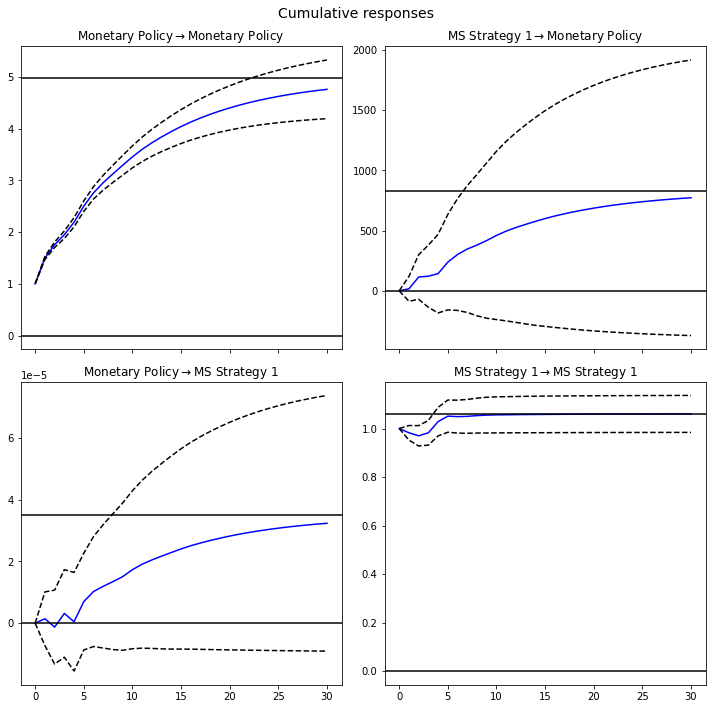

In [162]:
irf = results.irf(30)
irf.plot_cum_effects(orth=False)
plt.tight_layout()

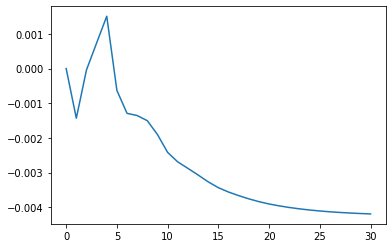

In [154]:
plt.plot(irf.cum_effects[:,1,0])